# **EIASR 21Z - Face Mask Detection**

We used this [project](https://www.kaggle.com/meghanatiyyali560/sailaja-meghana-project) as a guide how to use annotations provided with [image dataset we used](https://www.kaggle.com/andrewmvd/face-mask-detection). 

## **1. Environment preparation**

### Imports

In [1]:
import os
import glob
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import display
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras_preprocessing.image import ImageDataGenerator
from xml.etree import ElementTree
from pandas import DataFrame

### Constants

In [2]:
path = 'drive/MyDrive/datasets/face-mask-detection'

BATCH_SIZE = 64
SEED_SIZE = 42
EPOCHS = 24
image_target_size = (32, 32)

key_cropped = 'cropped_image_file'
key_label = 'label'
key_file = 'file'
key_image_file = 'image_file'
key_annotation = 'annotation_file'

annotations_dir = path + '/annotations'
images_dir = path + '/images'
temp_dir = path + '/temp'
cropped_dir = temp_dir + '/cropped_images'
augmented_dir = temp_dir + '/augmented_cropped_images'

classifier_path = 'drive/MyDrive/models/classifier-2.h5'

train_df_file_name = path + '/train_df.csv'
validation_df_file_name = path + '/validation_df.csv'
test_df_file_name = path + '/test_df.csv'
aug_train_df_file_name = path + '/augmented_cropped_images.csv'

### Optional cleanup

In [ ]:
os.mkdir(temp_dir)
os.mkdir(cropped_dir)

!ls 'drive/MyDrive/datasets/face-mask-detection'
!ls 'drive/MyDrive/datasets/face-mask-detection/temp'

annotations		      images  test_df.csv
augmented_cropped_images.csv  temp    train_df.csv
cropped_images


In [ ]:
shutil.rmtree(temp_dir)

In [ ]:
!ls 'drive/MyDrive/datasets/face-mask-detection'

annotations		      images  test_df.csv
augmented_cropped_images.csv  temp    train_df.csv


## **2. Test dataset preparation**

In [3]:
def dataset_stats(dataframe):
  sorted_label_df = DataFrame(dataframe['label'].value_counts()).reset_index()
  sorted_label_df.rename(columns = {'index': 'label', 'label': 'count'}, inplace = True)
  display(sorted_label_df)

### Read existing set

In [4]:
train_df = pd.read_csv(train_df_file_name, encoding='utf-8')
test_df = pd.read_csv(test_df_file_name, encoding='utf-8')

train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [5]:
train_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
703,124,193,148,218,without_mask,maksssksksss522,267,400,maksssksksss522.xml,maksssksksss522.png,cropped_images/maksssksksss522-1288.png
526,287,158,296,169,without_mask,maksssksksss750,400,268,maksssksksss750.xml,maksssksksss750.png,cropped_images/maksssksksss750-148.png
782,385,25,396,46,without_mask,maksssksksss385,400,245,maksssksksss385.xml,maksssksksss385.png,cropped_images/maksssksksss385-1658.png
749,2,56,16,74,without_mask,maksssksksss453,400,300,maksssksksss453.xml,maksssksksss453.png,cropped_images/maksssksksss453-1480.png
68,238,34,262,69,with_mask,maksssksksss2,400,290,maksssksksss2.xml,maksssksksss2.png,cropped_images/maksssksksss2-96.png
...,...,...,...,...,...,...,...,...,...,...,...
795,221,57,248,81,without_mask,maksssksksss702,600,317,maksssksksss702.xml,maksssksksss702.png,cropped_images/maksssksksss702-1747.png
318,368,75,395,104,with_mask,maksssksksss157,400,225,maksssksksss157.xml,maksssksksss157.png,cropped_images/maksssksksss157-411.png
492,236,161,273,195,without_mask,maksssksksss110,400,267,maksssksksss110.xml,maksssksksss110.png,cropped_images/maksssksksss110-35.png
757,133,51,146,73,without_mask,maksssksksss453,400,300,maksssksksss453.xml,maksssksksss453.png,cropped_images/maksssksksss453-1489.png


### Prepare new dataset

In [ ]:
data = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 
        'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_dir + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag:
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))

        if 'object' in element.tag:
            for attribute in list(element):
                if 'name' in attribute.tag:
                    name = attribute.text
                    data['label'] += [name]
                    data['width'] += [width]
                    data['height'] += [height]
                    data['file'] += [annotation.split('/')[-1][0:-4]]
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            data['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            data['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            data['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            data['ymax'] += [ymax]


#### Crop images

In [ ]:
df = DataFrame(data)
df[key_annotation] = df[key_file] + '.xml'
df[key_image_file] = df[key_file] + '.png'
df[key_cropped] = df[key_file]

df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_weared_incorrect,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11
...,...,...,...,...,...,...,...,...,...,...,...
4067,247,78,285,107,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4068,312,82,331,112,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4069,331,93,371,135,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703
4070,384,116,400,156,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703


In [ ]:
def crop(write=False):
  for i in range(len(df)):
      image_path = images_dir + '/' + df[key_image_file].iloc[i]
      
      df[key_cropped].iloc[i] = df[key_cropped].iloc[i] + '-' + str(i) + '.png'
      cropped_image_filename = df[key_cropped].iloc[i]
      
      xmin = df['xmin'].iloc[i]
      ymin = df['ymin'].iloc[i]
      xmax = df['xmax'].iloc[i]
      ymax = df['ymax'].iloc[i]
      
      if write:
        image = cv2.imread(image_path)
        cropped_image = image[ymin:ymax, xmin:xmax]
        cropped_image_dir = os.path.join(cropped_dir + '/', cropped_image_filename) 
        cv2.imwrite(cropped_image_dir, cropped_image)

In [ ]:
crop(True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,23,114,77,172,mask_weared_incorrect,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-0.png
1,147,157,200,211,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-1.png
2,201,191,230,234,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-2.png
3,243,192,293,247,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-3.png
4,309,182,346,224,with_mask,maksssksksss11,400,267,maksssksksss11.xml,maksssksksss11.png,maksssksksss11-4.png
...,...,...,...,...,...,...,...,...,...,...,...
4067,247,78,285,107,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4067.png
4068,312,82,331,112,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4068.png
4069,331,93,371,135,with_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4069.png
4070,384,116,400,156,without_mask,maksssksksss703,400,267,maksssksksss703.xml,maksssksksss703.png,maksssksksss703-4070.png


In [ ]:
df = df[df.label != 'mask_weared_incorrect']
df[key_cropped] = 'cropped_images/' + df[key_cropped]
classes = list(df[key_label].unique())
dataset_stats(df)

,label,count
0,with_mask,3232
1,without_mask,717


In [ ]:
masks = df[df.label == 'with_mask']
no_masks = df[df.label == 'without_mask']

In [ ]:
n = min([len(masks), len(no_masks)])
n = n / 3

In [ ]:
train_df = masks[:2*n].append(no_masks[:2*n], ignore_index=True)
test_df = masks[2*n+1:3*n].append(no_masks[2*n+1:3*n], ignore_index=True)

In [ ]:
train_df.to_csv(train_df_file_name, encoding='utf-8', index=False)
test_df.to_csv(test_df_file_name, encoding='utf-8', index=False)

In [ ]:
dataset_stats(train_df)

,label,count
0,with_mask,477
1,without_mask,477


### Calculate image target size

In [ ]:
image_width = []
image_height = []

for i in range(len(train_df)):
    cropped_image_path = cropped_dir + '/' + train_df[key_cropped].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [ ]:
image_target_size = (int(np.median(image_width)), int(np.median(image_height)))
image_target_size

(24, 22)

### Dataset statistics

In [ ]:
dataset_stats(train_df)

,label,count
0,without_mask,239
1,with_mask,239


In [ ]:
dataset_stats(test_df)

,label,count
0,without_mask,238
1,with_mask,238


### Loading datasets

In [5]:
training_image_generator = ImageDataGenerator(rescale = 1. / 255.,
                                              validation_split = 0.25)

training_generator = training_image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = temp_dir,
    x_col = key_cropped,
    y_col = key_label,
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

validation_generator = training_image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = temp_dir,
    x_col = key_cropped,
    y_col = key_label,
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 717 validated image filenames belonging to 2 classes.
Found 239 validated image filenames belonging to 2 classes.


In [ ]:
input_shape = [int(np.median(image_width)), int(np.median(image_height)), 3]

## **3. Model preparation for transfer learning - ResNet50 option**

### Preparing ResNet50 model

In [6]:
base_input_shape = (32, 32, 3)
weights = 'imagenet'

base_model = ResNet50(weights=weights, 
                      include_top=False, 
                      input_shape=base_input_shape)

94781440/94765736 [==============================] - 1s 0us/step


### Freezing base layers

In [7]:
for layer in base_model.layers:
    layer.trainable = False

### Adding Global Avg Pooling 2D and Dense layer

In [8]:
num_classes = 2

global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = keras.layers.Dense(num_classes, activation='softmax')(global_avg_pooling)

classifier = keras.models.Model(inputs=base_model.input,
                                outputs=outputs,
                                name='ResNet50')

In [ ]:
classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## **4. Model preparation for transfer learning - Custom model**

In [7]:
inputs = keras.Input(shape=(32, 32, 3))

conv1 = keras.layers.Conv2D(filters=10, kernel_size=3, activation = 'relu')(inputs)
conv2 = keras.layers.Conv2D(filters=10, kernel_size=3, activation = 'relu')(conv1)

pool1 = keras.layers.MaxPool2D(pool_size = 2, padding = 'valid')(conv2)

conv3 = keras.layers.Conv2D(filters=10, kernel_size=3, activation = 'relu')(pool1)
conv4 = keras.layers.Conv2D(filters=10, kernel_size=3, activation = 'relu')(conv3)

pool2 = keras.layers.MaxPool2D(pool_size = 2, padding = 'valid')(conv4)

flatten1 = keras.layers.Flatten()(pool2)
dense1 = keras.layers.Dense(8, activation = 'relu')(flatten1)
dropout1 = keras.layers.Dropout(0.1)(dense1)

flatten2 = keras.layers.Flatten()(dropout1)
dense2 = keras.layers.Dense(2, activation = 'softmax')(flatten2)
dropout2 = keras.layers.Dropout(0.1)(dense2)

classifier = keras.Model(inputs, dropout2)

## **5. Model training**

### Enable mechanisms preventing overlearning/ interrupting learning process

In [10]:
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=4,
                          verbose=1)

checkpoint = ModelCheckpoint(classifier_path,
                             monitor="val_loss",
                             mode='min',
                             save_best_only=True,
                             verbose=1)

### Define training

In [11]:
def train(classifier, learning_rate, showStats=False, path=classifier_path):
  #training_generator.reset()
  #validation_generator.reset()
  
  callbacks = [earlystop, checkpoint]
  
  classifier.compile(loss='binary_crossentropy',
                    #optimizer=RMSprop(learning_rate=learning_rate),
                    #optimizer=Adadelta(learning_rate=learning_rate),
                    optimizer=Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])

  history = classifier.fit(training_generator,
                           epochs=18,
                           steps_per_epoch=len(training_generator),
                           callbacks=callbacks,
                           validation_data=validation_generator,
                           validation_steps=len(validation_generator))

  classifier.save(path)

  if showStats:
    stats(history)

  return history

def stats(history):
  # summarize history for accuracy
  plt.figure(figsize=(10,10))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Start training process (ResNet50)

Epoch 1/18
12/12 [==============================] - ETA: 0s - loss: 1.1616 - accuracy: 0.4728 
Epoch 00001: val_loss improved from inf to 0.75432, saving model to drive/MyDrive/models/classifier-2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


12/12 [==============================] - 215s 18s/step - loss: 1.1616 - accuracy: 0.4728 - val_loss: 0.7543 - val_accuracy: 0.4770
Epoch 2/18
12/12 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.5565
Epoch 00002: val_loss improved from 0.75432 to 0.74149, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 7s 562ms/step - loss: 0.6978 - accuracy: 0.5565 - val_loss: 0.7415 - val_accuracy: 0.5314
Epoch 3/18
12/12 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5523
Epoch 00003: val_loss improved from 0.74149 to 0.71800, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 6s 518ms/step - loss: 0.6972 - accuracy: 0.5523 - val_loss: 0.7180 - val_accuracy: 0.4812
Epoch 4/18
12/12 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6722
Epoch 00004: val_loss improved from 0.71800 to 0.58225, saving model to drive/MyDrive/models/classifier-2.h

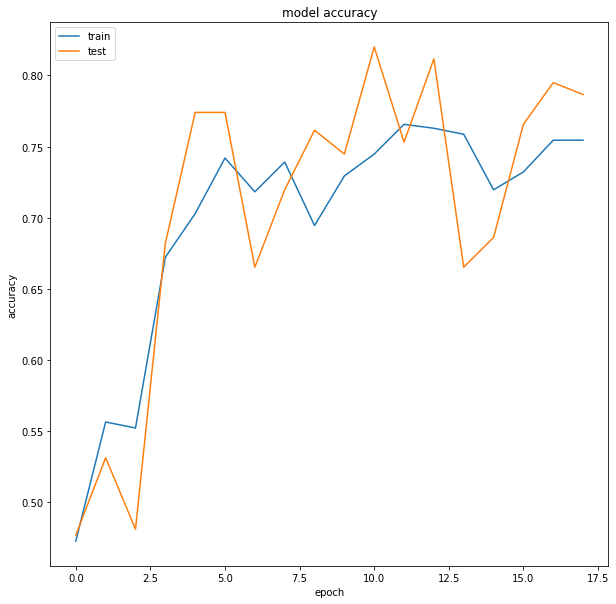

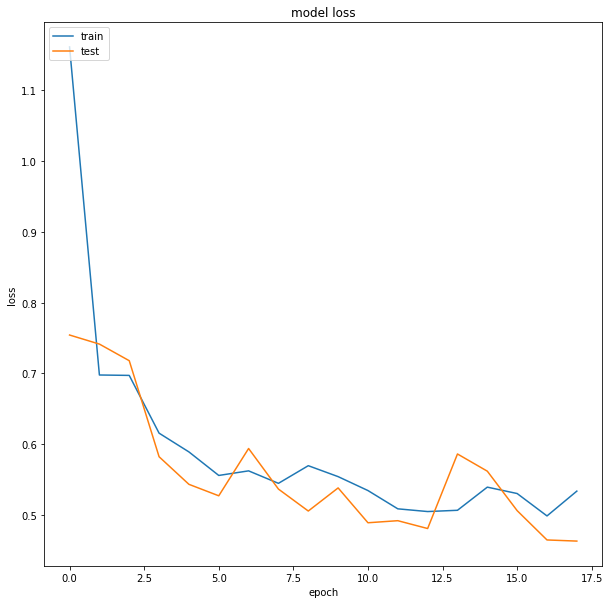

In [12]:
history = train(classifier, 0.01, showStats=True)

### Fine tuning

In [ ]:
base_model.trainable = True

print('Number of layers in the base model: ', len(base_model.layers))
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  190


In [ ]:
def fine_tune(learning_rate, initialEpoch=1, showStats=False):
  callbacks = [earlystop, checkpoint]
  
  classifier.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
                     metrics=['accuracy'])

  fine_tune_epochs = 10
  total_epochs =  EPOCHS + fine_tune_epochs

  history = classifier.fit(training_generator,
                           epochs=total_epochs,
                           callbacks=callbacks,
                           initial_epoch=initialEpoch,
                           validation_data=validation_generator)

  classifier.save(classifier_path)

  if showStats:
    stats(history)

  return history

In [ ]:
fine_tune(rate, history.epoch[-1], True)

In [ ]:
loss1, accuracy1 = classifier.evaluate(test_generator)

In [ ]:
print("initial loss: {:.2f}".format(loss1))
print("initial accuracy: {:.2f}".format(accuracy1))

### Simplified model: start training process

Epoch 1/18
12/12 [==============================] - ETA: 0s - loss: 1.6923 - accuracy: 0.4895 
Epoch 00001: val_loss improved from inf to 0.66695, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 234s 21s/step - loss: 1.6923 - accuracy: 0.4895 - val_loss: 0.6669 - val_accuracy: 0.5146
Epoch 2/18
12/12 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.5244
Epoch 00002: val_loss improved from 0.66695 to 0.60009, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 3s 230ms/step - loss: 1.3912 - accuracy: 0.5244 - val_loss: 0.6001 - val_accuracy: 0.5774
Epoch 3/18
12/12 [==============================] - ETA: 0s - loss: 1.2963 - accuracy: 0.7015
Epoch 00003: val_loss improved from 0.60009 to 0.52747, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 3s 210ms/step - loss: 1.2963 - accuracy: 0.7015 - val_loss: 0.5275 - val_accuracy: 0.9079
E

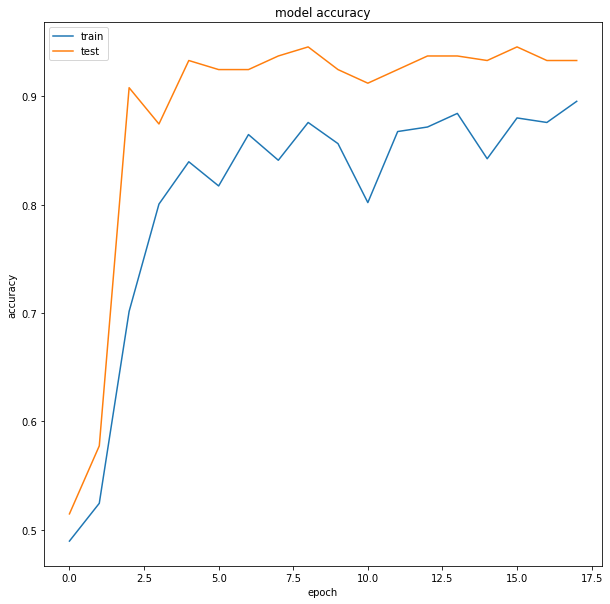

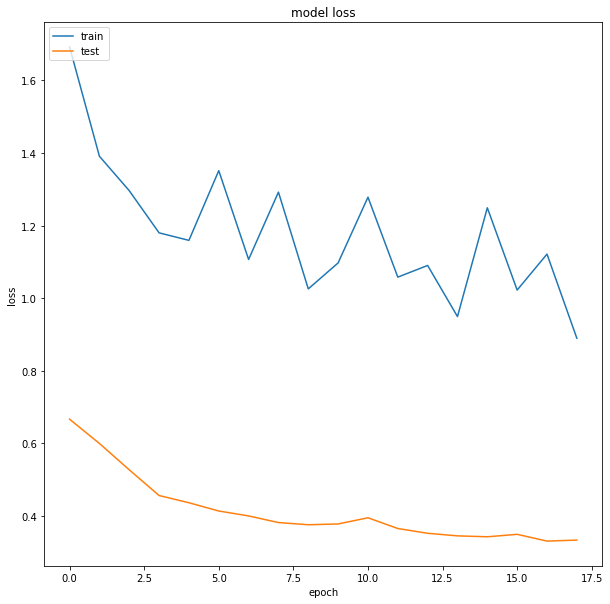

In [12]:
# best one
history = train(classifier, 0.001, showStats=True)

Epoch 1/18
12/12 [==============================] - ETA: 0s - loss: 6.8213 - accuracy: 0.5202 
Epoch 00001: val_loss improved from inf to 8.59904, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 212s 18s/step - loss: 6.8213 - accuracy: 0.5202 - val_loss: 8.5990 - val_accuracy: 0.4393
Epoch 2/18
12/12 [==============================] - ETA: 0s - loss: 7.4699 - accuracy: 0.5063
Epoch 00002: val_loss did not improve from 8.59904
12/12 [==============================] - 3s 217ms/step - loss: 7.4699 - accuracy: 0.5063 - val_loss: 8.5990 - val_accuracy: 0.4393
Epoch 3/18
12/12 [==============================] - ETA: 0s - loss: 7.5117 - accuracy: 0.5007
Epoch 00003: val_loss improved from 8.59904 to 8.59904, saving model to drive/MyDrive/models/classifier-2.h5
12/12 [==============================] - 3s 220ms/step - loss: 7.5117 - accuracy: 0.5007 - val_loss: 8.5990 - val_accuracy: 0.4393
Epoch 4/18
12/12 [==============================] - ETA: 0s

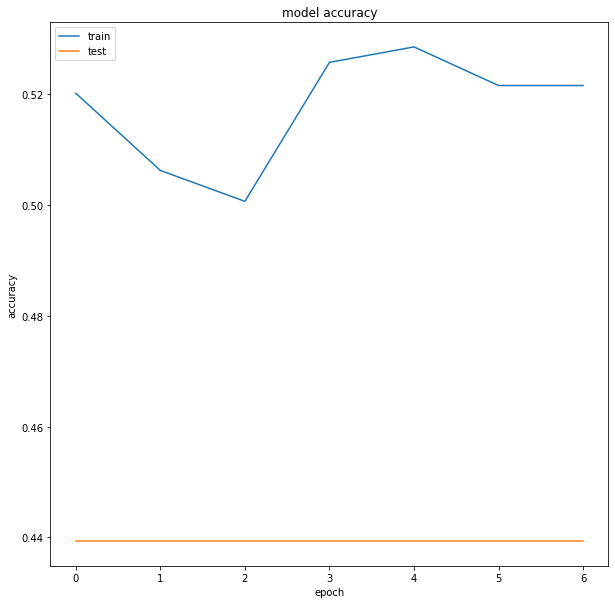

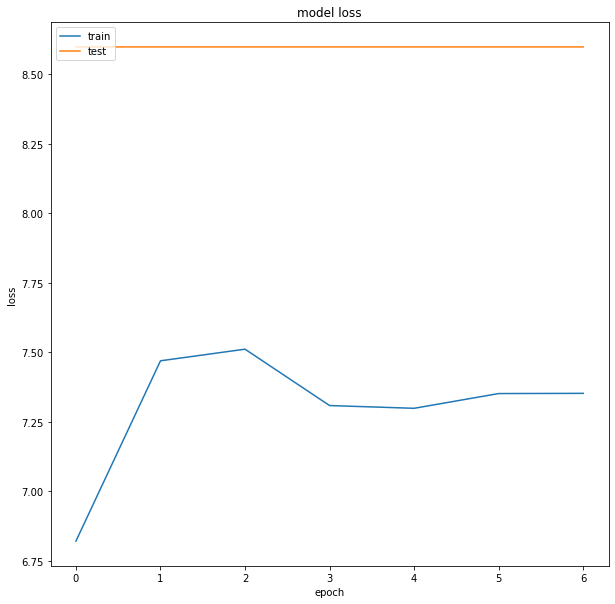

In [10]:
history = train(classifier, 0.1, showStats=True)

Epoch 1/24
6/6 [==============================] - ETA: 0s - loss: 1.2642 - accuracy: 0.5453
Epoch 00001: val_loss improved from inf to 0.65219, saving model to drive/MyDrive/models/classifier.h5
6/6 [==============================] - 3s 389ms/step - loss: 1.2642 - accuracy: 0.5453 - val_loss: 0.6522 - val_accuracy: 0.4895
Epoch 2/24
6/6 [==============================] - ETA: 0s - loss: 1.2923 - accuracy: 0.5342
Epoch 00002: val_loss improved from 0.65219 to 0.59678, saving model to drive/MyDrive/models/classifier.h5
6/6 [==============================] - 2s 309ms/step - loss: 1.2923 - accuracy: 0.5342 - val_loss: 0.5968 - val_accuracy: 0.8033
Epoch 3/24
6/6 [==============================] - ETA: 0s - loss: 1.2070 - accuracy: 0.7657
Epoch 00003: val_loss improved from 0.59678 to 0.52253, saving model to drive/MyDrive/models/classifier.h5
6/6 [==============================] - 2s 320ms/step - loss: 1.2070 - accuracy: 0.7657 - val_loss: 0.5225 - val_accuracy: 0.7782
Epoch 4/24
6/6 [====

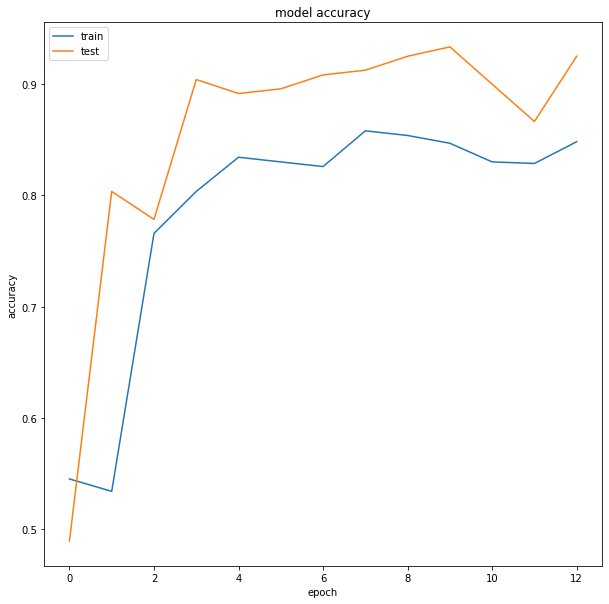

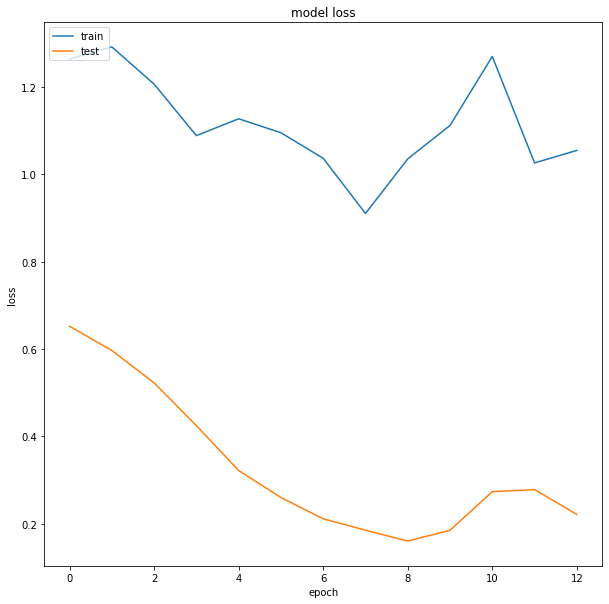

In [ ]:
# batch 128
history = train(classifier, 0.001, showStats=True)

Epoch 1/24
12/12 [==============================] - ETA: 0s - loss: 1.3035 - accuracy: 0.6792 
Epoch 00001: val_loss improved from inf to 0.60625, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 218s 18s/step - loss: 1.3035 - accuracy: 0.6792 - val_loss: 0.6063 - val_accuracy: 0.6151
Epoch 2/24
12/12 [==============================] - ETA: 0s - loss: 1.3400 - accuracy: 0.7517
Epoch 00002: val_loss improved from 0.60625 to 0.54792, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 2s 186ms/step - loss: 1.3400 - accuracy: 0.7517 - val_loss: 0.5479 - val_accuracy: 0.7113
Epoch 3/24
12/12 [==============================] - ETA: 0s - loss: 1.4445 - accuracy: 0.6625
Epoch 00003: val_loss improved from 0.54792 to 0.52889, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 2s 175ms/step - loss: 1.4445 - accuracy: 0.6625 - val_loss: 0.5289 - val_accuracy: 0.7197
Epoch 4

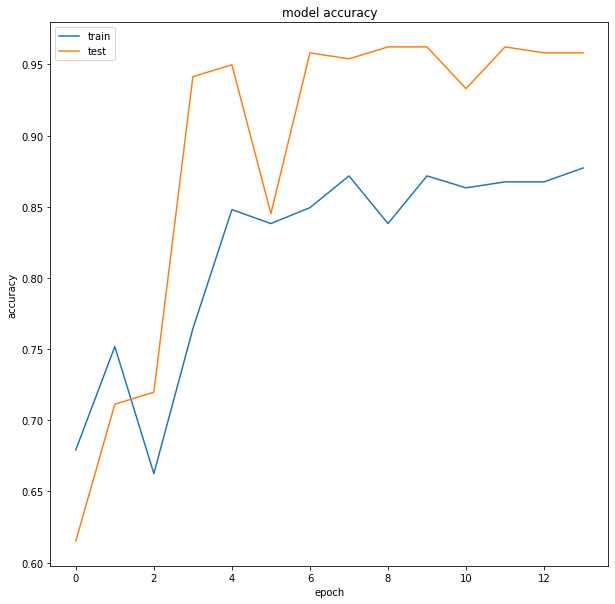

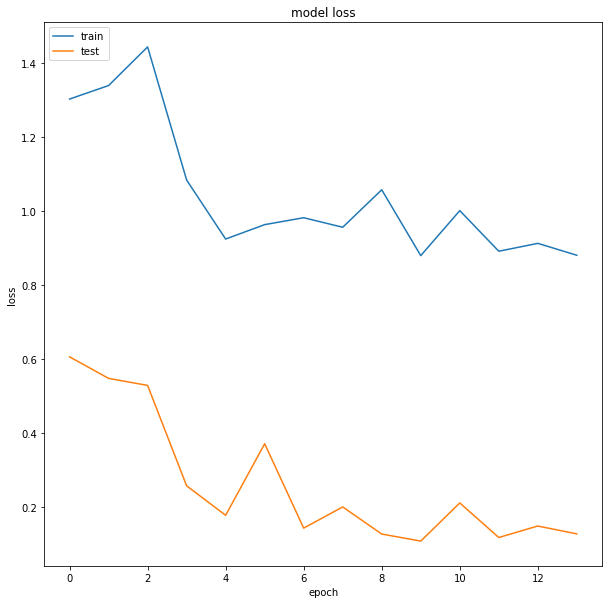

In [ ]:
history = train(classifier, 0.01, showStats=True)

Epoch 1/16
12/12 [==============================] - ETA: 0s - loss: 1.1320 - accuracy: 0.6416
Epoch 00001: val_loss improved from inf to 0.38873, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 3s 227ms/step - loss: 1.1320 - accuracy: 0.6416 - val_loss: 0.3887 - val_accuracy: 0.8661
Epoch 2/16
12/12 [==============================] - ETA: 0s - loss: 0.9649 - accuracy: 0.8354
Epoch 00002: val_loss improved from 0.38873 to 0.26803, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 2s 174ms/step - loss: 0.9649 - accuracy: 0.8354 - val_loss: 0.2680 - val_accuracy: 0.8912
Epoch 3/16
12/12 [==============================] - ETA: 0s - loss: 1.1355 - accuracy: 0.8257
Epoch 00003: val_loss improved from 0.26803 to 0.26460, saving model to drive/MyDrive/models/classifier.h5
12/12 [==============================] - 2s 174ms/step - loss: 1.1355 - accuracy: 0.8257 - val_loss: 0.2646 - val_accuracy: 0.8954
Epoch 4/

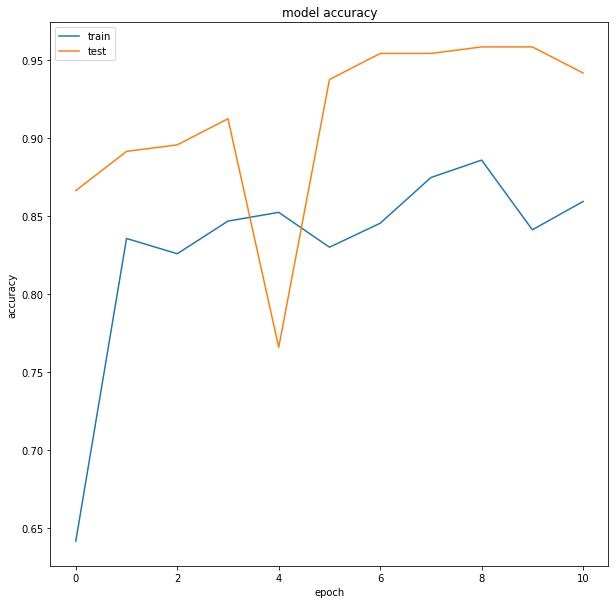

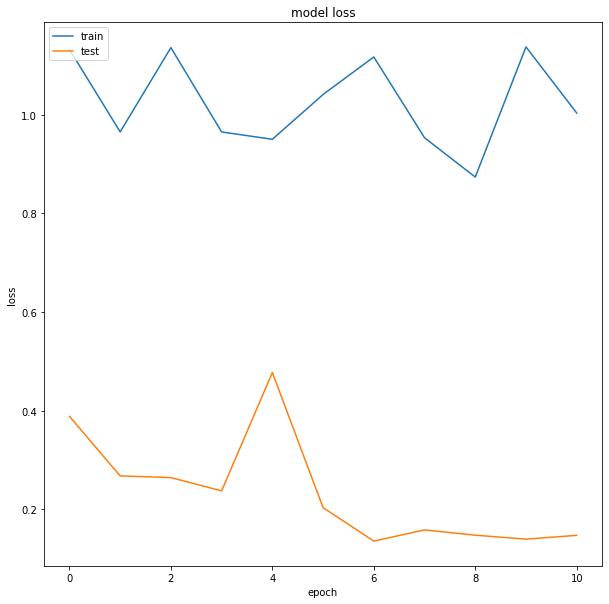

In [ ]:
history = train(classifier, 0.005, showStats=True)

Epoch 1/16
23/23 [==============================] - ETA: 0s - loss: 1.9548 - accuracy: 0.6341
Epoch 00001: val_loss improved from inf to 0.87722, saving model to drive/MyDrive/models/classifier-simplified-2.h5
23/23 [==============================] - 120s 5s/step - loss: 1.9548 - accuracy: 0.6341 - val_loss: 0.8772 - val_accuracy: 0.0000e+00
Epoch 2/16
23/23 [==============================] - ETA: 0s - loss: 2.0478 - accuracy: 0.6103
Epoch 00002: val_loss improved from 0.87722 to 0.85440, saving model to drive/MyDrive/models/classifier-simplified-2.h5
23/23 [==============================] - 2s 106ms/step - loss: 2.0478 - accuracy: 0.6103 - val_loss: 0.8544 - val_accuracy: 0.0000e+00
Epoch 3/16
23/23 [==============================] - ETA: 0s - loss: 2.3250 - accuracy: 0.5936
Epoch 00003: val_loss improved from 0.85440 to 0.75646, saving model to drive/MyDrive/models/classifier-simplified-2.h5
23/23 [==============================] - 3s 138ms/step - loss: 2.3250 - accuracy: 0.5936 - va

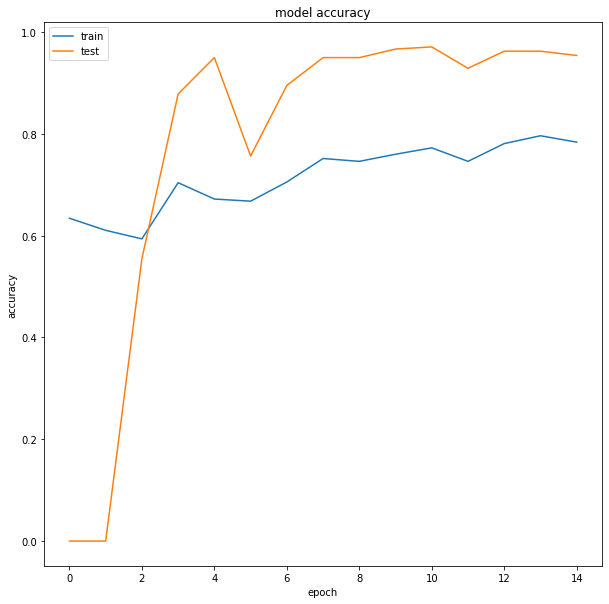

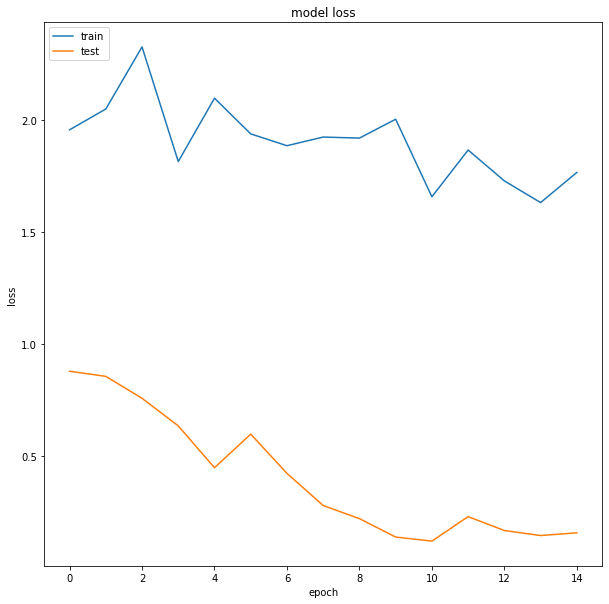

In [ ]:
history = train(classifier, 0.001, showStats=True)

## **6. Results evaluation**

### Evaluate results:

In [13]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from pandas import DataFrame
from keras_preprocessing.image import ImageDataGenerator

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [14]:
def prediction_stats(y_pred):
  print('Confusion Matrix')

  label_names = ['with_mask', 'without_mask']
  matrix = confusion_matrix(generator.classes, y_pred)
  sns.heatmap(matrix,
              annot = True,
              fmt='g',
              xticklabels=label_names,
              yticklabels=label_names)
  
  print('Classification Report')
  print(classification_report(generator.classes, y_pred, target_names=label_names))

def short_score_report(y_pred, generator, name):
  print('Score Report - ' + name)
  lin_score = accuracy_score(generator.labels, y_pred)
  print(lin_score)

In [15]:
# ..or use classifier reference if it is possible
model = classifier

In [21]:
# load model
model = tf.keras.models.load_model('drive/MyDrive/models/classifier.h5')

In [16]:
test_df = pd.read_csv(test_df_file_name)

In [17]:
image_target_size = (32, 32)

test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_image_generator.flow_from_dataframe(
    dataframe = test_df,
    directory = temp_dir,
    x_col = key_cropped,
    y_col = key_label,
    batch_size = BATCH_SIZE,
    seed = SEED_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 476 validated image filenames belonging to 2 classes.


In [18]:
generator = test_generator
generator.reset()

pred = model.predict(generator, 
                     batch_size=BATCH_SIZE,
                     steps=len(generator), 
                     verbose=1)

8/8 [==============================] - 100s 14s/step


In [19]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,

### Simplified model:

In [20]:
short_score_report(y_pred, generator, 'Simplified 0.001 - batch 64')

Score Report - Simplified 0.001 - batch 64
0.5252100840336135


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.53      0.50      0.51       238
without_mask       0.52      0.55      0.54       238

    accuracy                           0.53       476
   macro avg       0.53      0.53      0.52       476
weighted avg       0.53      0.53      0.52       476



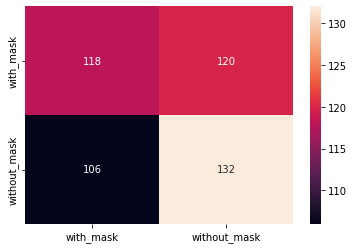

In [21]:
prediction_stats(y_pred)

In [ ]:
short_score_report(y_pred, generator, 'Simplified 0.01 - batch 128')

Score Report - Simplified 0.01 - batch 128
0.5189075630252101


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.52      0.46      0.49       238
without_mask       0.52      0.58      0.54       238

    accuracy                           0.52       476
   macro avg       0.52      0.52      0.52       476
weighted avg       0.52      0.52      0.52       476



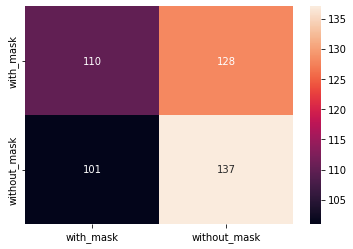

In [ ]:
prediction_stats(y_pred)

In [ ]:
short_score_report(y_pred, generator, 'Simplified 0.01')

Score Report - Simplified 0.01
0.523109243697479


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.52      0.50      0.51       238
without_mask       0.52      0.55      0.54       238

    accuracy                           0.52       476
   macro avg       0.52      0.52      0.52       476
weighted avg       0.52      0.52      0.52       476



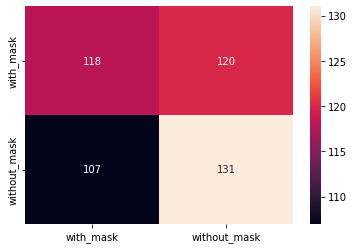

In [ ]:
prediction_stats(y_pred)

In [ ]:
short_score_report(y_pred, generator, 'Simplified 0.005')

Score Report - Simplified 0.005
0.5252100840336135


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.53      0.51      0.52       238
without_mask       0.52      0.54      0.53       238

    accuracy                           0.53       476
   macro avg       0.53      0.53      0.53       476
weighted avg       0.53      0.53      0.53       476



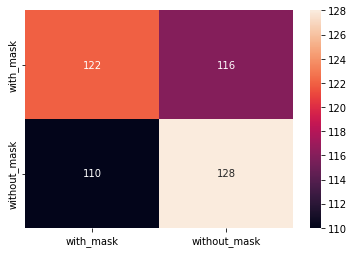

In [ ]:
prediction_stats(y_pred)

In [ ]:
short_score_report(y_pred, generator, 'Simplified 0.001')

Score Report - Simplified 0.001
0.5252100840336135


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.53      0.52      0.52       238
without_mask       0.52      0.53      0.53       238

    accuracy                           0.53       476
   macro avg       0.53      0.53      0.53       476
weighted avg       0.53      0.53      0.53       476



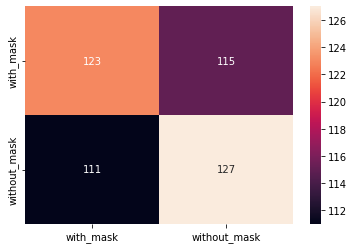

In [ ]:
prediction_stats(y_pred)

In [18]:
short_score_report(y_pred, generator, 'Simplified 0.1')

Score Report - Simplified 0.1
0.5


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00       238
without_mask       0.50      1.00      0.67       238

    accuracy                           0.50       476
   macro avg       0.25      0.50      0.33       476
weighted avg       0.25      0.50      0.33       476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


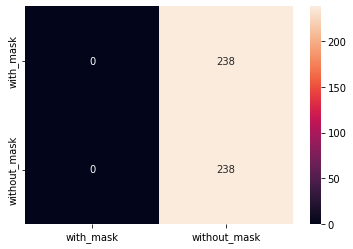

In [19]:
prediction_stats(y_pred)

### ResNet50:

In [27]:
short_score_report(y_pred, generator, 'ResNet50 0.0001')

Score Report - ResNet50 0.0001
0.5084033613445378


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.51      0.32      0.39       238
without_mask       0.51      0.70      0.59       238

    accuracy                           0.51       476
   macro avg       0.51      0.51      0.49       476
weighted avg       0.51      0.51      0.49       476



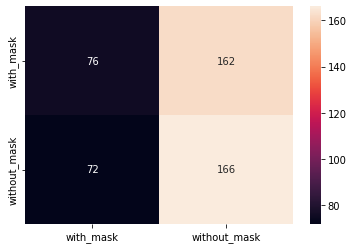

In [28]:
prediction_stats(y_pred)

In [12]:
short_score_report(y_pred, generator, 'ResNet50 0.001')

Score Report - ResNet50 0.001
0.5


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00       238
without_mask       0.50      1.00      0.67       238

    accuracy                           0.50       476
   macro avg       0.25      0.50      0.33       476
weighted avg       0.25      0.50      0.33       476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


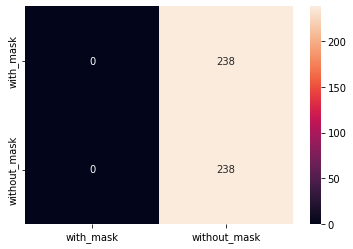

In [13]:
prediction_stats(y_pred)

In [19]:
short_score_report(y_pred, generator, 'ResNet50 0.01')

Score Report - ResNet50 0.01
0.5147058823529411


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.51      0.52      0.52       238
without_mask       0.51      0.51      0.51       238

    accuracy                           0.51       476
   macro avg       0.51      0.51      0.51       476
weighted avg       0.51      0.51      0.51       476



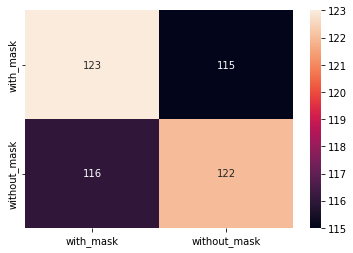

In [20]:
prediction_stats(y_pred)

In [25]:
short_score_report(y_pred, generator, 'ResNet50 0.05')

Score Report - ResNet50 0.05
0.523109243697479


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   with_mask       0.52      0.66      0.58       238
without_mask       0.53      0.39      0.45       238

    accuracy                           0.52       476
   macro avg       0.52      0.52      0.51       476
weighted avg       0.52      0.52      0.51       476



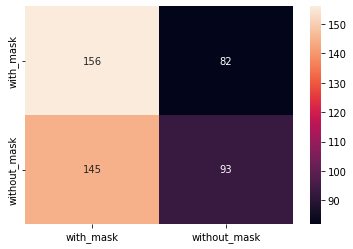

In [26]:
prediction_stats(y_pred)